# Working with `IntervalData`

## Introduction

The `IntervalData` class is a subclass of `IntervalDict` class of `Portion`, used to hold and work with data that is piecewise continuous. The most obvious usecase is spectral data, where a continuous spectrum (for example from the Sun) can be then filtered in two distinct bands. The filters can be box filters (1.0 at the pass band, zero otherwise) or more complex filters with tapered edges.

When combined with interpolators and resampling, this provides a very powerful framework to simulate light (or generally RF waves) spectrum, interacting with filters or other surfaces that modify the amplitude and spectral properties as it goes through them or bounces off them.

We have to start with the opticks package import as well as some other useful packages.

In [1]:
# If opticks import fails, try to locate the module
# This can happen building the docs
import os

try:
    import opticks
except ModuleNotFoundError:
    os.chdir(os.path.join("..", "..", ".."))
    os.getcwd()

In [2]:
import numpy as np
import portion as P

from opticks import u, Q_

%matplotlib inline

# pint support to matplotlib
u.setup_matplotlib()

import warnings

warnings.filterwarnings("always")

## Working with `IntervalData`

As a simple example, we start with a filter defined from -20 Hz to +20 Hz. It is transparent between -4 Hz and 0 Hz and between 2 Hz and 5 Hz. Outside the range of validity, the filter is undefined and returns `None`, inside the range of validity it returns zero where it is "non-transparent" and 1.0 where it is "transparent".

Also, there is no such thing as a negative frequency in the absolute sense, but it is possible in the relative sense. It matters little for this example, though may be worth mentioning.

In [3]:
from opticks.utils.interval_data import IntervalData

data = P.IntervalDict()
# interval of validity
validity = P.closed(-10 * u.Hz, 10 * u.Hz)
data[validity] = 0
# data proper
first_rng = P.closed(-4 * u.Hz, 0 * u.Hz)
data[first_rng] = 1.0
second_rng = P.closed(2 * u.Hz, 5 * u.Hz)
data[second_rng] = 1.0

filter = IntervalData(data)

# filter definition
print(filter)
# interval of validity
print(filter.domain())

# data inside interval of validity but zero
print(filter.get_value((8 * u.Hz)))
# data outside interval of validity
print(filter.get_value((12 * u.Hz)))

{[<Quantity(-10, 'hertz')>,<Quantity(-4, 'hertz')>) | (<Quantity(0, 'hertz')>,<Quantity(2, 'hertz')>) | (<Quantity(5, 'hertz')>,<Quantity(10, 'hertz')>]: 0, [<Quantity(-4, 'hertz')>,<Quantity(0, 'hertz')>] | [<Quantity(2, 'hertz')>,<Quantity(5, 'hertz')>]: 1.0}
[<Quantity(-10, 'hertz')>,<Quantity(10, 'hertz')>]
0.0
None


For something a bit more interesting, we will define a quadratic function, though we will take discrete steps and initialise an interpolator, rather than using the analytical function directly.

The data is defined from -8 to + 8 Hz, therefore shorter than the filter definition. This will be important later, when we apply the "filter" to this function.

In [4]:
from opticks.utils.math_utils import InterpolatorWithUnits, InterpolatorWithUnitTypes

range = P.closed(-8 * u.Hz, 8 * u.Hz)

x = np.linspace(range.lower, range.upper, num=100, endpoint=True)

y = (0.5 * x.m) ** 2

ipol = InterpolatorWithUnits.from_ipol_method(
    InterpolatorWithUnitTypes.AKIMA, x, y, extrapolate=True
)

main_funct = IntervalData.from_interpolator(ipol)

print(main_funct)

{[<Quantity(-8.0, 'hertz')>,<Quantity(8.0, 'hertz')>]: <opticks.utils.math_utils.InterpolatorWithUnits object at 0x7014e401ce60>}


## Combining `IntervalData` Objects

The next step is `combine` the filter and the main function. This combine operation is defined as "stacking" the mathematical functions, interpolators or constants together in a list, for the proper internal regions of validity. Therefore, no resampling or evaluation actually takes place. The interpolators do not need to extrapolate. The underlying `IntervalDict` implementation takes care of the interval arithmetic and knows the intersections.

Also, the region of validity for the combined `IntervalDict` is necessarily the intersection of the two, as the behaviour of `filter` or `main_funct` is not defined outside their respective regions of validity. The combined item still has the larger interval of validity, but these ranges yield `None` as the value. This behaviour can be changed with the `missing` key for the `combine` operation, but should be done cautiously.

In [5]:
filtered_main = main_funct.combine(filter)

print(filtered_main)

{[<Quantity(-10, 'hertz')>,<Quantity(-8.0, 'hertz')>) | (<Quantity(8.0, 'hertz')>,<Quantity(10, 'hertz')>]: None, [<Quantity(-8.0, 'hertz')>,<Quantity(-4, 'hertz')>) | (<Quantity(0, 'hertz')>,<Quantity(2, 'hertz')>) | (<Quantity(5, 'hertz')>,<Quantity(8.0, 'hertz')>]: [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7014e401ce60>, 0], [<Quantity(-4, 'hertz')>,<Quantity(0, 'hertz')>] | [<Quantity(2, 'hertz')>,<Quantity(5, 'hertz')>]: [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7014e401ce60>, 1.0]}


To get the "stack" of functions at a certain point or region is possible using the `get` function. The `get_value` function evaluates all the "stacked" functions at the requested point and yields the result. 

In [6]:
x = 3 * u.Hz

# stack of functions at x
print(filtered_main.get(x))
# value at x
print(filtered_main.get_value(x))

range = P.closed(1 * u.Hz, 4 * u.Hz)
# stack of functions within the range
print(filtered_main.get(range))

[<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7014e401ce60>, 1.0]
2.2499999999999996
{[<Quantity(1, 'hertz')>,<Quantity(2, 'hertz')>): [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7014e401ce60>, 0], [<Quantity(2, 'hertz')>,<Quantity(4, 'hertz')>]: [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7014e401ce60>, 1.0]}


# Flattening the Functions Stack: Resampling

After successive `combine` operations, the functions stack can pile high, with multiple interpolations slowing down the operations. The `resample` function 'flattens' the stack, via a resampling and setting up a new interpolator.

The resampling is done for each *atomic* interval within the `IntervalData` object. This process decomposes all the intervals into atomic intervals, processes them and puts them back together into a new `IntervalData` object

The following example shows the atomic intervals.

In [7]:
atomic_int = filtered_main.to_atomic()

# List atomic intervals and corresponding functions
for interval, functs in atomic_int:
    print(interval, functs)

[<Quantity(-10, 'hertz')>,<Quantity(-8.0, 'hertz')>) None
(<Quantity(8.0, 'hertz')>,<Quantity(10, 'hertz')>] None
[<Quantity(-8.0, 'hertz')>,<Quantity(-4, 'hertz')>) [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7014e401ce60>, 0]
(<Quantity(0, 'hertz')>,<Quantity(2, 'hertz')>) [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7014e401ce60>, 0]
(<Quantity(5, 'hertz')>,<Quantity(8.0, 'hertz')>] [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7014e401ce60>, 0]
[<Quantity(-4, 'hertz')>,<Quantity(0, 'hertz')>] [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7014e401ce60>, 1.0]
[<Quantity(2, 'hertz')>,<Quantity(5, 'hertz')>] [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7014e401ce60>, 1.0]


The resampling is carried out respecting the content of the functions stack at each atomic interval:
- If one item of the functions stack is `None`, then the entire interval value is set to `None`
- If one item of the functions stack is zero, then the entire interval value is set to zero.
- If all the items of the functions stack are numbers, then the entire interval value is set to the multiplication of these numbers.
- Finally, if one item of the multiple item functions stack is a continuous function or interpolator, then the entire interval value is resampled.

In this example, the resampling for the first two intervals in the list would automatically result in `None`, the next three intervals automatically zero and the last two intervals would be resampled.

The sample sizes are important only when an interpolation is needed. The `approx_stepsize` argument instructs the method to set the sample size accordingly. The approximate bit comes from the fact that, the samples are computed by dividing the interval by the stepsize and rounding down to convert them into integers.

In [8]:
approx_stepsize = 0.15 * u.Hz

resampled_filt_main = filtered_main.resample(approx_stepsize)

# original
print(filtered_main)

# resampled
print(resampled_filt_main)

{[<Quantity(-10, 'hertz')>,<Quantity(-8.0, 'hertz')>) | (<Quantity(8.0, 'hertz')>,<Quantity(10, 'hertz')>]: None, [<Quantity(-8.0, 'hertz')>,<Quantity(-4, 'hertz')>) | (<Quantity(0, 'hertz')>,<Quantity(2, 'hertz')>) | (<Quantity(5, 'hertz')>,<Quantity(8.0, 'hertz')>]: [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7014e401ce60>, 0], [<Quantity(-4, 'hertz')>,<Quantity(0, 'hertz')>] | [<Quantity(2, 'hertz')>,<Quantity(5, 'hertz')>]: [<opticks.utils.math_utils.InterpolatorWithUnits object at 0x7014e401ce60>, 1.0]}
{[<Quantity(-10, 'hertz')>,<Quantity(-8.0, 'hertz')>) | (<Quantity(8.0, 'hertz')>,<Quantity(10, 'hertz')>]: None, [<Quantity(-8.0, 'hertz')>,<Quantity(-4, 'hertz')>) | (<Quantity(0, 'hertz')>,<Quantity(2, 'hertz')>) | (<Quantity(5, 'hertz')>,<Quantity(8.0, 'hertz')>]: 0, [<Quantity(-4, 'hertz')>,<Quantity(0, 'hertz')>]: <opticks.utils.math_utils.InterpolatorWithUnits object at 0x7014e40383c0>, [<Quantity(2, 'hertz')>,<Quantity(5, 'hertz')>]: <opticks.utils.math_uti

Inspecting the output, we can see that the intervals with `None` and zero are still merged as a single, non-atomic interval, whereas the interpolated interval is now made up of two non-adjacent parts.

## Plotting the Data

The `IntervalDict` objects can be plotted easily. It is a `matplotlib` based convenience class for rapid visualisation and does not enable extensive customisation via the interface.

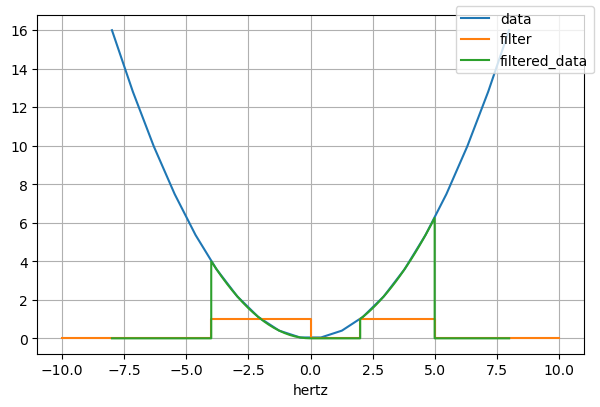

In [9]:
from opticks.utils.interval_data import IntervalDataPlot

interval_data_dict = {
    "data": main_funct,
    "filter": filter,
    "filtered_data": filtered_main,
}

plot = IntervalDataPlot(interval_data_dict)

While the out-of-the-box formatting is sensible, it is possible to change things once the plot is populated. The `fig` and `ax` objects are also available for further customisation.

Text(0.5, 1.0, 'Filter and Filtered Data')

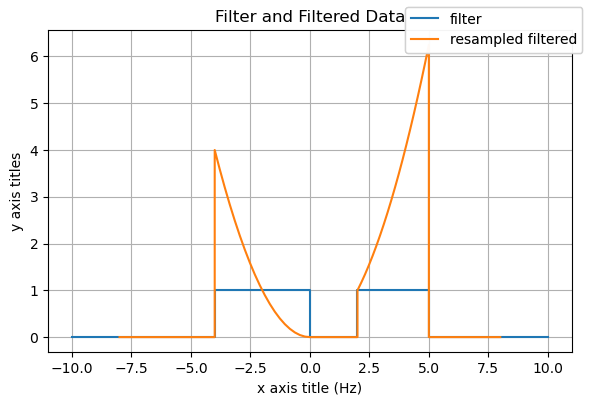

In [10]:
plot2 = IntervalDataPlot({"filter": filter, "resampled filtered": resampled_filt_main})
plot2.set_plot_style(
    xlabel="x axis title (Hz)",
    ylabel="y axis titles",
    height=10 * u.cm,
    width=15 * u.cm,
)

# example only, can be also done via set_plot_style
plot2.ax.set_title("Filter and Filtered Data")